# Training Code for Missing Pixels task

**NOTE**: This notebook is only meant to be **read only**. Running it directly without modifications will not work properly.

If you'd like to test the saved trained models, open this colab: [collab link]

This code is meant to be run on a local machine with tensorflow-gpu installed and training data downloaded in the local folder. The data used for this training is ImageNet with face obfuscation, which is available for public on the ImageNet website ([paper](https://www.image-net.org/face-obfuscation/) | [download](https://image-net.org/download.php)), but any large image datasets can work for this code.

Specifications:
- Python 3.11.2
- Tensorflow (GPU) 2.12.1 (CUDA 11.8.89, cuDNN 8.6.0.163)
- Numpy 1.24.3
- Matplotlib 3.7.2
- OpenCV (opencv-python) 4.8.0.74
- Pandas 2.0.3
- TQDM 4.65.0

This code was run on a machine running Debian 12 with NVIDIA Quadro P4000.

### Importing libraries and setting up

In [1]:
import os
import os.path
from os import walk, listdir
from os.path import isfile, join

# disables "You must feed a value for placeholder tensor..." warning log. 
# see https://github.com/tensorflow/tensorflow/issues/59779
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

# for diagrams?
plt.rcParams["figure.dpi"] = 120

from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
    display(HTML('''<style>
        body {
          font-size: 16px;
        }
        '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
    shell.events.register('pre_execute', adjust_font_size)

# memory management
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

# checking if gpu is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-07-27 02:34:14.776248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 02:34:15.350704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


### Defining Functions and Static Parameters

In [2]:
# Static Parameters
NUM_INP_NODES = 64 # unused
NUM_OUT_NODES = 4 
BLOCK_SIZE = 8
IMAGE_SIZE = (256, 256)

# target (missing pixel) indices
M1 = 3
M2 = 4 

def is_missing_pixel(r, c):
  return (r >= M1 and c >= M1 and r <= M2 and c <= M2)

def do_parse_img(img, inps, tgts):
    num_rows = img.shape[0]
    num_cols = img.shape[1]

    for r0 in range(0, num_rows, BLOCK_SIZE):
        for c0 in range(0, num_cols, BLOCK_SIZE):
            # for every 8x8 block segments in the image...
            
            # get 2d matrices of the input and target
            inp = img[r0:(r0 + BLOCK_SIZE), c0:(c0 + BLOCK_SIZE)].copy() # should be 8, 8
            tgt = img[(r0 + M1):(r0 + M2 + 1), (c0 + M1):(c0 + M2 + 1)].copy() # should be 2, 2
            
            # set the missing pixel as 0 in input
            inp[M1:(M2 + 1), M1:(M2 + 1)] = np.zeros(tgt.shape)
            
            # flatten the target from shape of 2, 2 to just 4.
            tgt = tgt.flatten()

            # append to lists of all inputs, normalize to [0, 1]
            inps.append(inp.copy() / 255.0)
            tgts.append(tgt.copy() / 255.0)

def parse_x_y(path, img_num=1):
    # store all the filenames in the folder
    fnames = []
    for subdir, dirs, files in os.walk(path):
        for file in files:
            fnames.append(os.path.join(subdir, file))
            
    # convert the image to grayscale and 256x256, then get the inputs and targets
    inps = []
    tgts = []
    for img_fname in tqdm(fnames[:img_num]):
        img = cv.imread(img_fname, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, IMAGE_SIZE, cv.INTER_LINEAR)
        img = img.astype(np.float64)

        do_parse_img(img, inps, tgts)
    
    return np.array(inps), np.array(tgts)

def imshow(img, title="", cmap=None, vmin=0, vmax=255, frameon=True, dpi=72):
    fig = plt.figure(figsize=[img.shape[1]/dpi, img.shape[0]/dpi], \
                           frameon=frameon)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.savefig("{}.png".format(title), bbox_inches='tight', dpi=600)
    plt.show()

### Load training data

In [3]:
# set the number of images used for training and validation:
NUM_TRN = 16000
NUM_VAL = 4000

# set the path of the dataset
img_train_path = "./missing_pixels/train_blurred"
img_val_path = "./missing_pixels/val_blurred"
    
print("Parsing training images...")
X_trn, y_trn = parse_x_y(img_train_path, NUM_TRN)
print("Parsing validation images...")
X_val, y_val = parse_x_y(img_val_path, NUM_VAL)

Parsing training images...


100%|██████████| 16000/16000 [01:40<00:00, 158.43it/s]


Parsing validation images...


100%|██████████| 4000/4000 [00:24<00:00, 163.86it/s]


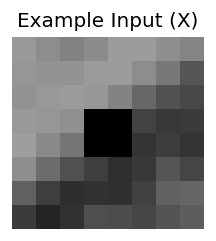

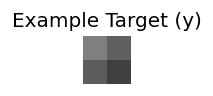

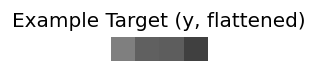

In [4]:
imshow(X_trn[0]*255, "Example Input (X)", cmap="gray", dpi=5)
imshow(np.reshape(y_trn[0]*255, (2,2)), "Example Target (y)", cmap="gray", dpi=5)
imshow(np.reshape(y_trn[0]*255, (1,4)), "Example Target (y, flattened)", cmap="gray", dpi=5)

### Defining and compiling the model

In [5]:
def cnn():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), padding="same", input_shape=(BLOCK_SIZE, BLOCK_SIZE, 1)))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, kernel_size=(4,4), padding="same"))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256, kernel_size=(3,3), padding="same"))
    model.add(ReLU())
    model.add(Flatten())
    model.add(Dense(NUM_OUT_NODES, activation="sigmoid"))

    return model
    
cnn().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 64)          640       
                                                                 
 re_lu (ReLU)                (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         131200    
                                                                 
 re_lu_1 (ReLU)              (None, 4, 4, 128)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 128)        0         
 2D)                                                    

2023-07-27 02:36:45.480995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6726 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:65:00.0, compute capability: 6.1


In [6]:
# if in case you want to reuse an existing model
reuse_pre_model = False

model_fname = "model_cnn_missingpixel_20KData.h5"
if reuse_pre_model and os.path.exists(model_fname):
    print("Reloading previous model: ", model_fname)
    model = load_model(model_fname)
else:
    model = cnn()
    adam_ = tf.keras.optimizers.Adam(learning_rate=0.001)#, clipnorm=1.0)
    model.compile(optimizer=adam_, metrics=['mean_squared_error'], loss = 'mean_squared_error')

### Training

In [7]:
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3) # to avoid overfitting
callbacks_list = [checkpoint, early_stop]

# fit the model
history = model.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=20, batch_size=512,
                    shuffle=True, verbose=1, callbacks=callbacks_list)

# saving the training history 
np.save('history_20KData.npy', history.history)

Epoch 1/20


2023-07-27 02:36:49.306950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-27 02:36:49.546128: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f044712fb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-27 02:36:49.546157: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2023-07-27 02:36:49.549966: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-27 02:36:49.654753: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31995/32000 [============================>.] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 1: loss improved from inf to 0.00251, saving model to model_cnn_missingpixel_20KData.h5
32000/32000 [==============================] - 293s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/20
31995/32000 [============================>.] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 2: loss improved from 0.00251 to 0.00228, saving model to model_cnn_missingpixel_20KData.h5
32000/32000 [==============================] - 304s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 3/20
31998/32000 [============================>.] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 3: loss improved from 0.00228 to 0.00225, saving model to model_cnn_missingpixel_20KData.h5
32000/32000 [==============================] - 305s 10ms/step - loss: 0.0022

### Plotting Training Result

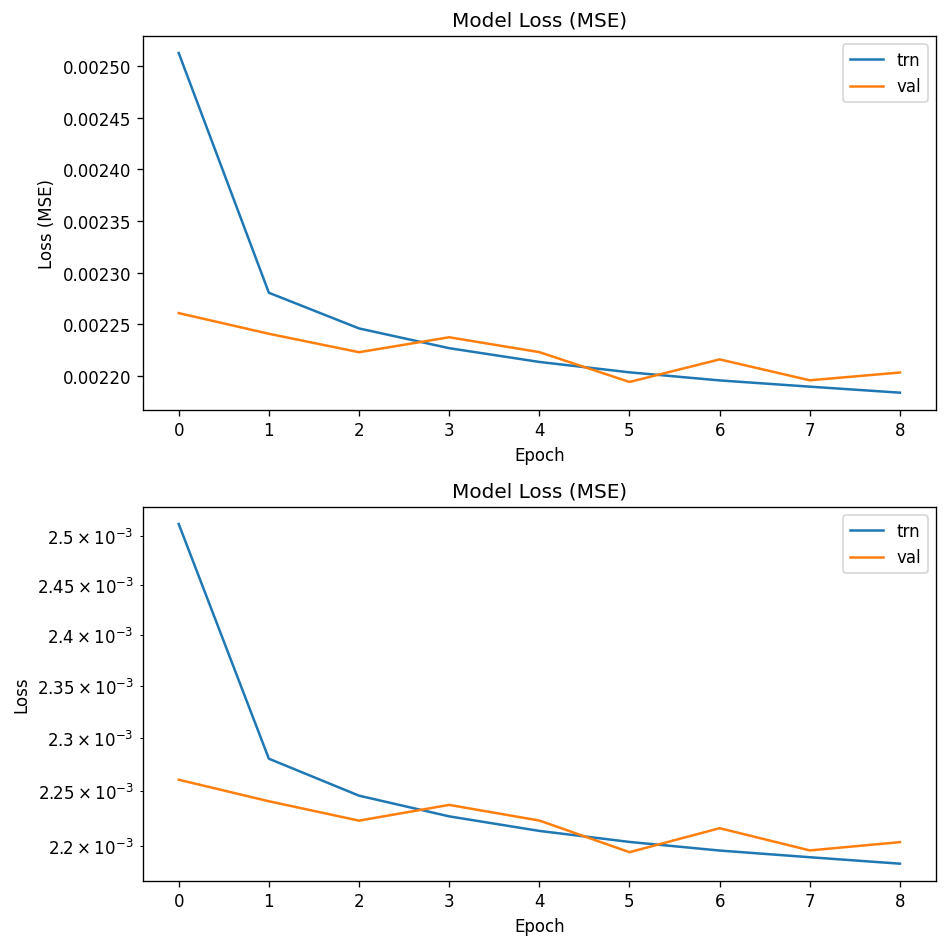

In [8]:
def plot_trn_hist(hist, fname):    
    fig = plt.figure(figsize=(8, 8))

    plt.subplot(2,1,1)
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['trn', 'val'], loc='upper right')
    plt.tight_layout()

    plt.subplot(2,1,2)
    plt.semilogy(hist['loss'])
    plt.semilogy(hist['val_loss'])
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['trn', 'val'], loc='upper right')
    plt.tight_layout()

    plt.savefig("{}.png".format(fname), bbox_inches='tight', dpi=600)
    plt.show()
    
plot_trn_hist(history.history, "history_20KData")

# if using from previously saved history data, use this to load the training history
# trn_history= np.load('history_2KData.npy',allow_pickle='TRUE').item()
# plot_trn_hist(trn_history, "history_2KData")

### Testing on a picture

32/32 [==============================] - 0s 1ms/step
MSE = 7.46875004
MSE (normalized) = 0.00011486


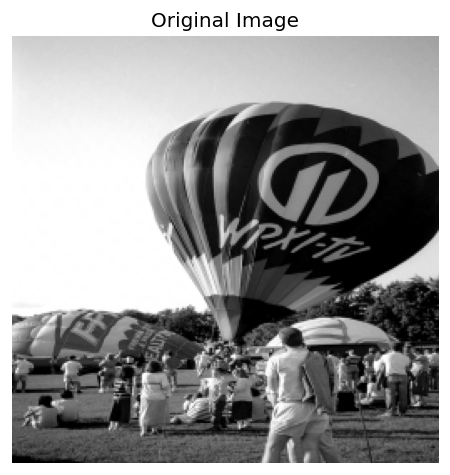

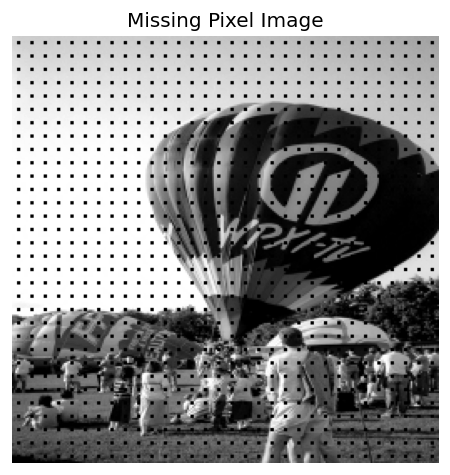

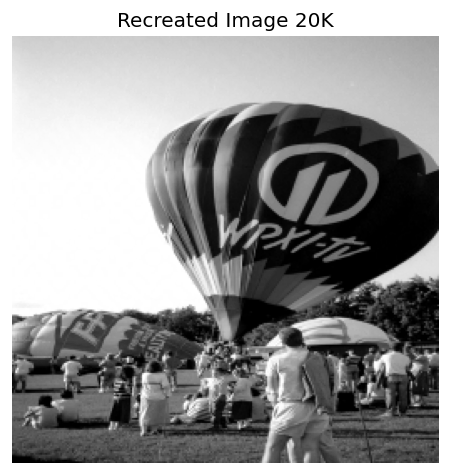

In [9]:
img_test_path = "./missing_pixels/test_images/balloon.bmp"
img = cv.imread(img_test_path, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

inps = []
tgts = []
do_parse_img(img, inps, tgts)

X_tst, y_tst = np.array(inps), np.array(tgts)

# predict the missing pixels
y_tst_prd = model.predict(X_tst)

num_rows = img.shape[0]
num_cols = img.shape[1]

missing_pixel_img = np.zeros((num_rows, num_cols))
rec_img = np.zeros((num_rows, num_cols))

blk_pos = 0
for r0 in range(0, num_rows, BLOCK_SIZE):
    for c0 in range(0, num_cols, BLOCK_SIZE):
        # fill in the outer and context pixels
        for r in range(BLOCK_SIZE):
            for c in range(BLOCK_SIZE):
                assert(r0 + r < num_rows)
                assert(c0 + c < num_cols)
                if not is_missing_pixel(r, c):
                    missing_pixel_img[r0 + r, c0 + c] = img[r0 + r, c0 + c]
                    rec_img[r0 + r, c0 + c] = img[r0 + r, c0 + c]
        
        out = y_tst_prd[blk_pos]
        blk_pos += 1

        # fill in the missing pixels
        pos = 0
        for r in range(BLOCK_SIZE):
            for c in range(BLOCK_SIZE):
                assert(r0 + r < num_rows)
                assert(c0 + c < num_cols)
                if is_missing_pixel(r, c):
                    rec_img[r0 + r, c0 + c] = 255*out[pos]
                    pos += 1

# compute the MSE between the original and reconstructed images
err = rec_img - img
print("MSE =", "{:.8f}".format((err**2).mean()))
print("MSE (normalized) =", "{:.8f}".format(((err/255)**2).mean()))
imshow(img, "Original Image", "gray", dpi=72)
imshow(missing_pixel_img, "Missing Pixel Image", "gray", dpi=72)
imshow(rec_img, "Recreated Image 20K", "gray", dpi=72)